## Social network Graph Link Prediction - Facebook Challenge

### Problem Statement : Given a directed social graph, have to predict missing links to recommend users.

In [0]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from scipy.sparse.linalg import svds, eigs

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!ls

drive  sample_data


In [4]:
#reading graph
if not os.path.isfile('/content/drive/My Drive/mandatory_15/train_woheader.csv'):
    traincsv = pd.read_csv('/content/drive/My Drive/mandatory_15/train.csv')
    print(traincsv[traincsv.isna().any(1)])
    print(traincsv.info())
    print("Number of diplicate entries: ",sum(traincsv.duplicated()))
    traincsv.to_csv('/content/drive/My Drive/mandatory_15/train_woheader.csv',header=False,index=False)
    print("saved the graph into file")
else:
    g=nx.read_edgelist('/content/drive/My Drive/mandatory_15/train_woheader.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 1862220
Number of edges: 9437519
Average in degree:   5.0679
Average out degree:   5.0679


Name: 
Type: DiGraph
Number of nodes: 66
Number of edges: 50
Average in degree:   0.7576
Average out degree:   0.7576


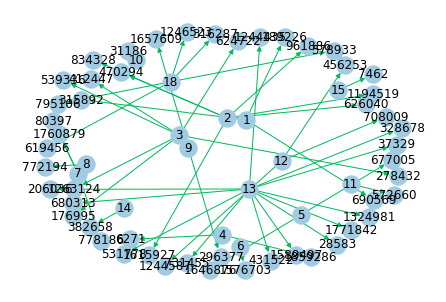

In [5]:
# Displaying a sub graph
if not os.path.isfile('train_woheader_sample.csv'):
    pd.read_csv('/content/drive/My Drive/mandatory_15/train.csv', nrows=50).to_csv('train_woheader_sample.csv',header=False,index=False)
    
subgraph=nx.read_edgelist('train_woheader_sample.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
# https://stackoverflow.com/questions/9402255/drawing-a-huge-graph-with-networkx-and-matplotlib

pos=nx.spring_layout(subgraph)
nx.draw(subgraph,pos,node_color='#A0CBE2',edge_color='#00bb5e',width=1,edge_cmap=plt.cm.Blues,with_labels=True)
plt.savefig("graph_sample.pdf")
print(nx.info(subgraph))

## 1. Exploratory Data Analysis

In [0]:
# No of Unique persons 
print("The number of unique persons",len(g.nodes()))

The number of unique persons 1862220


### 1.1 No of followers for each person

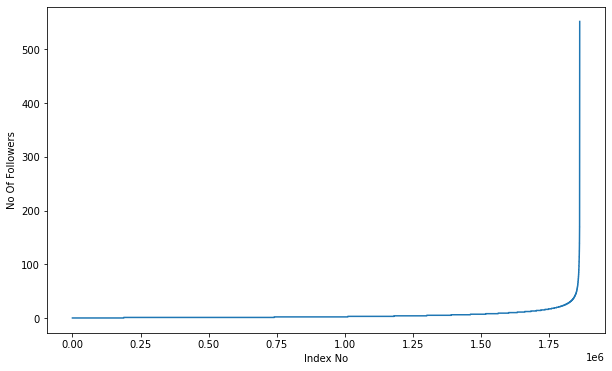

In [0]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

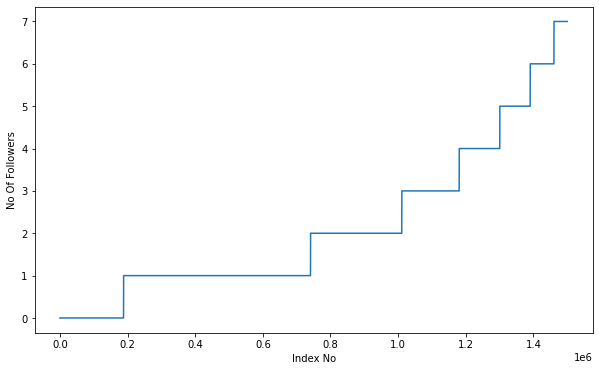

In [0]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

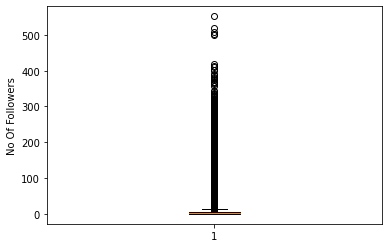

In [0]:
plt.boxplot(indegree_dist)
plt.ylabel('No Of Followers')
plt.show()

In [0]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(indegree_dist,90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 552.0


In [0]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(indegree_dist,99+(i/100)))

99.1 percentile value is 42.0
99.2 percentile value is 44.0
99.3 percentile value is 47.0
99.4 percentile value is 50.0
99.5 percentile value is 55.0
99.6 percentile value is 61.0
99.7 percentile value is 70.0
99.8 percentile value is 84.0
99.9 percentile value is 112.0
100.0 percentile value is 552.0


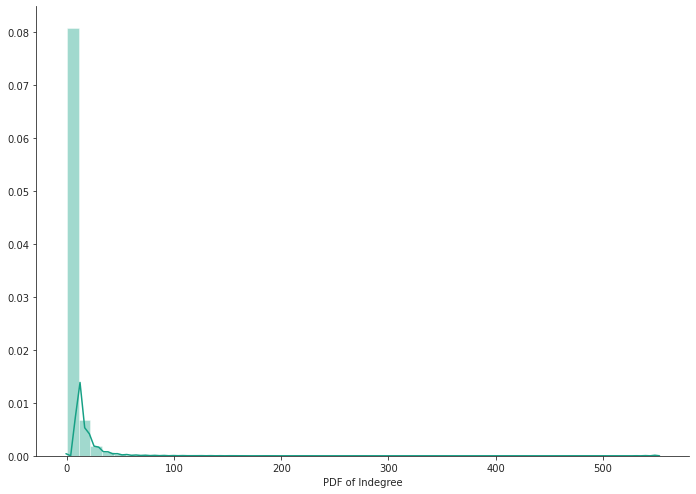

In [0]:
%matplotlib inline
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(indegree_dist, color='#16A085')
plt.xlabel('PDF of Indegree')
sns.despine()
#plt.show()

## 1.2 No of people each person is following

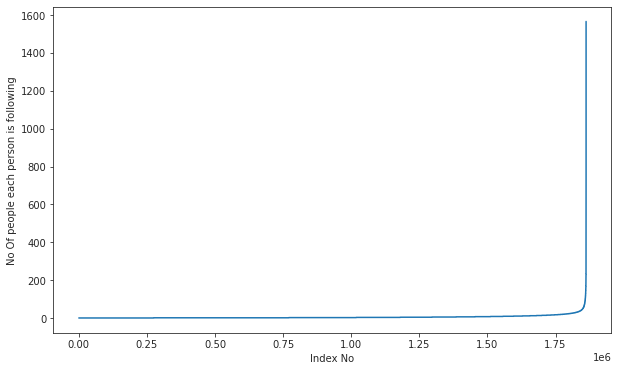

In [0]:
outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show()

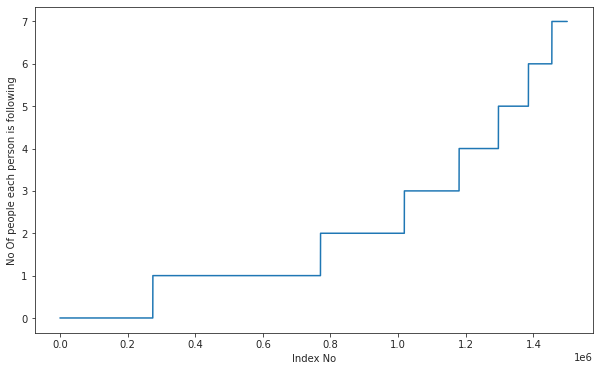

In [0]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show()

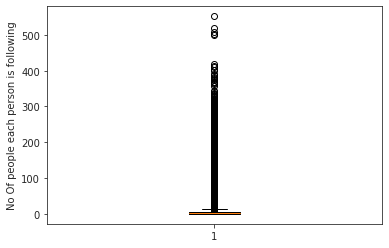

In [0]:
plt.boxplot(indegree_dist)
plt.ylabel('No Of people each person is following')
plt.show()

In [0]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(outdegree_dist,90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 1566.0


In [0]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(outdegree_dist,99+(i/100)))

99.1 percentile value is 42.0
99.2 percentile value is 45.0
99.3 percentile value is 48.0
99.4 percentile value is 52.0
99.5 percentile value is 56.0
99.6 percentile value is 63.0
99.7 percentile value is 73.0
99.8 percentile value is 90.0
99.9 percentile value is 123.0
100.0 percentile value is 1566.0


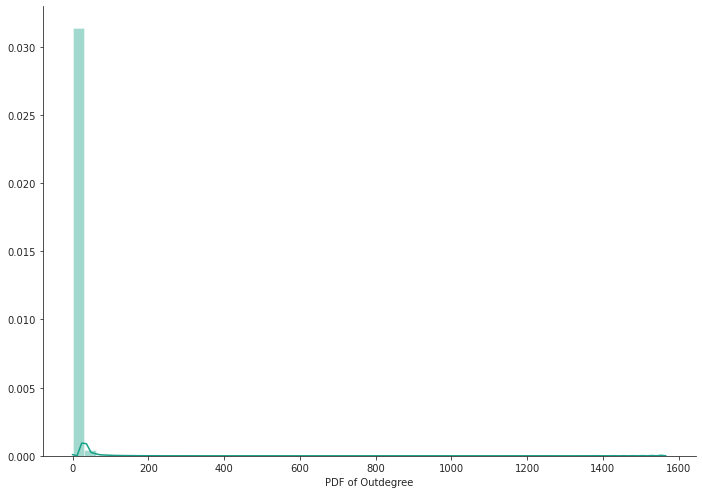

In [0]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(outdegree_dist, color='#16A085')
plt.xlabel('PDF of Outdegree')
sns.despine()

In [0]:
print('No of persons those are not following anyone are' ,sum(np.array(outdegree_dist)==0),'and % is',
                                sum(np.array(outdegree_dist)==0)*100/len(outdegree_dist) )

No of persons those are not following anyone are 274512 and % is 14.741115442858524


In [0]:
print('No of persons having zero followers are' ,sum(np.array(indegree_dist)==0),'and % is',
                                sum(np.array(indegree_dist)==0)*100/len(indegree_dist) )

No of persons having zero followers are 188043 and % is 10.097786512871734


In [0]:
count=0
for i in g.nodes():
    if len(list(g.predecessors(i)))==0 :
        if len(list(g.successors(i)))==0:
            count+=1
print('No of persons those are not not following anyone and also not having any followers are',count)

No of persons those are not not following anyone and also not having any followers are 0


## 1.3 both followers + following

In [0]:
from collections import Counter
dict_in = dict(g.in_degree())
dict_out = dict(g.out_degree())
d = Counter(dict_in) + Counter(dict_out)
in_out_degree = np.array(list(d.values()))

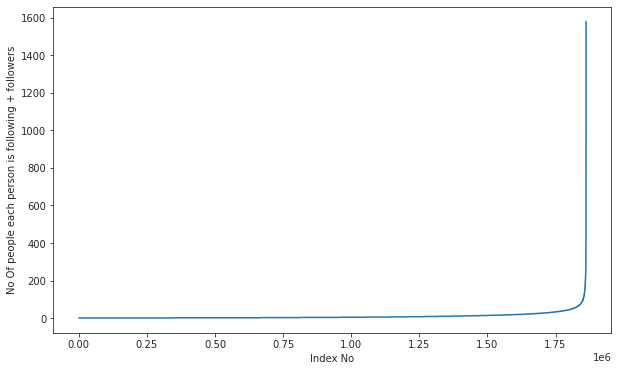

In [0]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

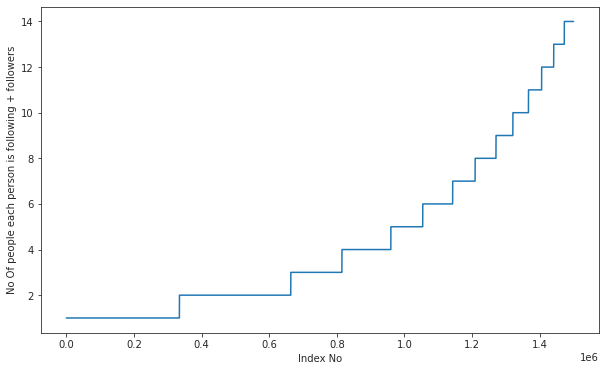

In [0]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

In [0]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(in_out_degree_sort,90+i))

90 percentile value is 24.0
91 percentile value is 26.0
92 percentile value is 28.0
93 percentile value is 31.0
94 percentile value is 33.0
95 percentile value is 37.0
96 percentile value is 41.0
97 percentile value is 48.0
98 percentile value is 58.0
99 percentile value is 79.0
100 percentile value is 1579.0


In [0]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(in_out_degree_sort,99+(i/100)))

99.1 percentile value is 83.0
99.2 percentile value is 87.0
99.3 percentile value is 93.0
99.4 percentile value is 99.0
99.5 percentile value is 108.0
99.6 percentile value is 120.0
99.7 percentile value is 138.0
99.8 percentile value is 168.0
99.9 percentile value is 221.0
100.0 percentile value is 1579.0


In [0]:
print('Min of no of followers + following is',in_out_degree.min())
print(np.sum(in_out_degree==in_out_degree.min()),' persons having minimum no of followers + following')

Min of no of followers + following is 1
334291  persons having minimum no of followers + following


In [0]:
print('Max of no of followers + following is',in_out_degree.max())
print(np.sum(in_out_degree==in_out_degree.max()),' persons having maximum no of followers + following')

Max of no of followers + following is 1579
1  persons having maximum no of followers + following


In [0]:
print('No of persons having followers + following less than 10 are',np.sum(in_out_degree<10))

No of persons having followers + following less than 10 are 1320326


In [0]:
print('No of weakly connected components',len(list(nx.weakly_connected_components(g))))
count=0
for i in list(nx.weakly_connected_components(g)):
    if len(i)==2:
        count+=1
print('weakly connected components wit 2 nodes',count)

No of weakly connected components 45558
weakly connected components wit 2 nodes 32195


# 2. Posing a problem as classification problem

## 2.1 Generating some edges which are not present in graph for supervised learning

### Generated Bad links from graph which are not in graph and whose shortest path is greater than 2.

In [6]:
%%time
###generating bad edges from given graph

import random

if not os.path.isfile('/content/drive/My Drive/mandatory_15/missing_edges_final.p'):
    #getting all set of edges
    r = csv.reader(open('/content/drive/My Drive/mandatory_15/train_woheader.csv','r'))
    edges = dict()
    for edge in r:
        edges[(edge[0], edge[1])] = 1
        
        
    missing_edges = set([])
    while (len(missing_edges)<9437519):
        a=random.randint(1, 1862220)
        b=random.randint(1, 1862220)
        tmp = edges.get((a,b),-1)
        if tmp == -1 and a!=b:
            try:
                if nx.shortest_path_length(g,source=a,target=b) > 2: 

                    missing_edges.add((a,b))
                else:
                    continue  
            except:  
                    missing_edges.add((a,b))              
        else:
            continue
    pickle.dump(missing_edges,open('/content/drive/My Drive/mandatory_15/missing_edges_final.p','wb'))
else:
    missing_edges = pickle.load(open('/content/drive/My Drive/mandatory_15/missing_edges_final.p','rb'))


CPU times: user 2.01 s, sys: 1.52 s, total: 3.53 s
Wall time: 4.93 s


In [8]:
missing_edges = pickle.load(open('/content/drive/My Drive/mandatory_15/missing_edges_final.p','rb'))
len(missing_edges)

9437519

## 2.2 Training and Test data split:

### Removed edges from Graph and used as test data and after removing used that graph for creating features for Train and test data

In [0]:
from sklearn.model_selection import train_test_split
if (not os.path.isfile('/content/drive/My Drive/mandatory_15/train_pos_after_eda.csv')) and (not os.path.isfile('/content/drive/My Drive/mandatory_15/test_pos_after_eda.csv')):
    #reading total data df
    df_pos = pd.read_csv('/content/drive/My Drive/mandatory_15/train.csv')
    df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])
    
    print("Number of nodes in the graph with edges", df_pos.shape[0])
    print("Number of nodes in the graph without edges", df_neg.shape[0])
    
    #Trian test split 
    #Spiltted data into 80-20 
    #positive links and negative links seperatly because we need positive training data only for creating graph 
    #and for feature generation
    X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.2, random_state=9)
    X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.2, random_state=9)
    
    print('='*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0],"=",y_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0],"=", y_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0],"=",y_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0],"=",y_test_neg.shape[0])

    #removing header and saving
    X_train_pos.to_csv('/content/drive/My Drive/mandatory_15/train_pos_after_eda.csv',header=False, index=False)
    X_test_pos.to_csv('/content/drive/My Drive/mandatory_15/test_pos_after_eda.csv',header=False, index=False)
    X_train_neg.to_csv('/content/drive/My Drive/mandatory_15/train_neg_after_eda.csv',header=False, index=False)
    X_test_neg.to_csv('/content/drive/My Drive/mandatory_15/test_neg_after_eda.csv',header=False, index=False)
else:
    #Graph from Traing data only 
    del missing_edges

In [10]:
if (os.path.isfile('/content/drive/My Drive/mandatory_15/train_pos_after_eda.csv')) and (os.path.isfile('/content/drive/My Drive/mandatory_15/test_pos_after_eda.csv')):        
    train_graph=nx.read_edgelist('/content/drive/My Drive/mandatory_15/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    test_graph=nx.read_edgelist('/content/drive/My Drive/mandatory_15/test_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
    print(nx.info(test_graph))
    
    # finding the unique nodes in the both train and test graphs
    train_nodes_pos = set(train_graph.nodes())
    test_nodes_pos = set(test_graph.nodes())

    trY_teY = len(train_nodes_pos.intersection(test_nodes_pos))
    trY_teN = len(train_nodes_pos - test_nodes_pos)
    teY_trN = len(test_nodes_pos - train_nodes_pos)

    print('no of people common in train and test -- ',trY_teY)
    print('no of people present in train but not present in test -- ',trY_teN)

    print('no of people present in test but not present in train -- ',teY_trN)
    print(' % of people not there in Train but exist in Test in total Test data are {} %'.format(teY_trN/len(test_nodes_pos)*100))

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399
Name: 
Type: DiGraph
Number of nodes: 1144623
Number of edges: 1887504
Average in degree:   1.6490
Average out degree:   1.6490
no of people common in train and test --  1063125
no of people present in train but not present in test --  717597
no of people present in test but not present in train --  81498
 % of people not there in Train but exist in Test in total Test data are 7.1200735962845405 %


In [0]:
#final train and test data sets
if (not os.path.isfile('/content/drive/My Drive/mandatory_15/train_after_eda.csv')) and \
(not os.path.isfile('/content/drive/My Drive/mandatory_15/test_after_eda.csv')) and \
(not os.path.isfile('/content/drive/My Drive/mandatory_15/test_y.csv')) and \
(not os.path.isfile('/content/drive/My Drive/mandatory_15/train_y.csv')) and \
(os.path.isfile('/content/drive/My Drive/mandatory_15/train_pos_after_eda.csv')) and \
(os.path.isfile('/content/drive/My Drive/mandatory_15/test_pos_after_eda.csv')) and \
(os.path.isfile('/content/drive/My Drive/mandatory_15/train_neg_after_eda.csv')) and \
(os.path.isfile('/content/drive/My Drive/mandatory_15/test_neg_after_eda.csv')):
    
    X_train_pos = pd.read_csv('/content/drive/My Drive/mandatory_15/train_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_pos = pd.read_csv('/content/drive/My Drive/mandatory_15/test_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_train_neg = pd.read_csv('/content/drive/My Drive/mandatory_15/train_neg_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_neg = pd.read_csv('/content/drive/My Drive/mandatory_15/test_neg_after_eda.csv', names=['source_node', 'destination_node'])

    print('='*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0])

    X_train = X_train_pos.append(X_train_neg,ignore_index=True)
    y_train = np.concatenate((y_train_pos,y_train_neg))
    X_test = X_test_pos.append(X_test_neg,ignore_index=True)
    y_test = np.concatenate((y_test_pos,y_test_neg)) 
    
    X_train.to_csv('/content/drive/My Drive/mandatory_15/train_after_eda.csv',header=False,index=False)
    X_test.to_csv('/content/drive/My Drive/mandatory_15/test_after_eda.csv',header=False,index=False)
    pd.DataFrame(y_train.astype(int)).to_csv('/content/drive/My Drive/mandatory_15/train_y.csv',header=False,index=False)
    pd.DataFrame(y_test.astype(int)).to_csv('/content/drive/My Drive/mandatory_15/test_y.csv',header=False,index=False)

In [12]:
X_train = pd.read_csv('/content/drive/My Drive/mandatory_15/train_after_eda.csv')
X_test = pd.read_csv('/content/drive/My Drive/mandatory_15/test_after_eda.csv')
y_train = pd.read_csv('/content/drive/My Drive/mandatory_15/train_y.csv')
y_test = pd.read_csv('/content/drive/My Drive/mandatory_15/test_y.csv')
print("Data points in train data",X_train.shape)
print("Data points in test data",X_test.shape)
print("Shape of traget variable in train",y_train.shape)
print("Shape of traget variable in test", y_test.shape)

Data points in train data (15100029, 2)
Data points in test data (3775007, 2)
Shape of traget variable in train (15100029, 1)
Shape of traget variable in test (3775007, 1)


# 3. Reading Data

In [3]:
train_graph=nx.read_edgelist('/content/drive/My Drive/mandatory_15/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(train_graph))

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399


# 4. Similarity Measures 

### 4.1 Jaccard Distance:\begin{equation}
j = \frac{|X\cap Y|}{|X \cup Y|} 
\end{equation}

In [0]:
#for followees
def jaccard_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
    except:
        return 0
    return sim

In [5]:
#one test case
print(jaccard_for_followees(273084,1505602))

0.0


In [6]:
#node 1635354 not in graph 
print(jaccard_for_followees(273084,1505602))

0.0


In [0]:
#for followers
def jaccard_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                 (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [0]:
print(jaccard_for_followers(273084,470294))

0.0


In [0]:
#node 1635354 not in graph 
print(jaccard_for_followees(669354,1635354))

0


### 4.2 Cosine distance \begin{equation}
CosineDistance = \frac{|X\cap Y|}{|X|\cdot|Y|} 
\end{equation}

In [0]:
#for followees
def cosine_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b))))))
        return sim
    except:
        return 0

In [0]:
print(cosine_for_followees(273084,1505602))

0.0


In [0]:
print(cosine_for_followees(273084,1635354))

0


In [0]:
def cosine_for_followers(a,b):
    try:
        
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                     (math.sqrt(len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [0]:
print(cosine_for_followers(2,470294))

0.02886751345948129


In [0]:
print(cosine_for_followers(669354,1635354))

0


# 5. Ranking Measures

# 5.1 Page Ranking

In [0]:
if not os.path.isfile('/content/drive/My Drive/mandatory_15/page_rank.p'):
    pr = nx.pagerank(train_graph, alpha=0.85)
    pickle.dump(pr,open('/content/drive/My Drive/mandatory_15/page_rank.p','wb'))
else:
    pr = pickle.load(open('/content/drive/My Drive/mandatory_15/page_rank.p','rb'))

In [0]:
print('min',pr[min(pr, key=pr.get)])
print('max',pr[max(pr, key=pr.get)])
print('mean',float(sum(pr.values())) / len(pr))

min 1.6556497245737814e-07
max 2.7098251341935827e-05
mean 5.615699699389075e-07


In [35]:
#for imputing to nodes which are not there in Train data
mean_pr = float(sum(pr.values())) / len(pr)
print(mean_pr)

5.615699699389075e-07


# 6.Other Graph Features

### 6.1 Shortest Path

In [0]:
#if has direct edge then deleting that edge and calculating shortest path
def compute_shortest_path_length(a,b):
    p=-1
    try:
        if train_graph.has_edge(a,b):
            train_graph.remove_edge(a,b)
            p= nx.shortest_path_length(train_graph,source=a,target=b)
            train_graph.add_edge(a,b)
        else:
            p= nx.shortest_path_length(train_graph,source=a,target=b)
        return p
    except:
        return -1

In [0]:
#testing
compute_shortest_path_length(77697, 826021)

10

In [0]:
#testing
compute_shortest_path_length(669354,1635354)

-1

### 6. Checking for same community

In [0]:
#getting weekly connected edges from graph 
wcc=list(nx.weakly_connected_components(train_graph))
def belongs_to_same_wcc(a,b):
    index = []
    if train_graph.has_edge(b,a):
        return 1
    if train_graph.has_edge(a,b):
            for i in wcc:
                if a in i:
                    index= i
                    break
            if (b in index):
                train_graph.remove_edge(a,b)
                if compute_shortest_path_length(a,b)==-1:
                    train_graph.add_edge(a,b)
                    return 0
                else:
                    train_graph.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in wcc:
                if a in i:
                    index= i
                    break
            if(b in index):
                return 1
            else:
                return 0

In [0]:
belongs_to_same_wcc(861, 1659750)

0

In [0]:
belongs_to_same_wcc(669354,1635354)

0

### 6.3 Adamic/Adar Index:

Adamic/Adar measures is defined as inverted sum of degrees of common neighbours for given two vertices.
$$A(x,y)=\sum_{u \in N(x) \cap N(y)}\frac{1}{log(|N(u)|)}$$

In [0]:
#adar index
def calc_adar_in(a,b):
    sum=0
    try:
        n=list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
        if len(n)!=0:
            for i in n:
                sum=sum+(1/np.log10(len(list(train_graph.predecessors(i)))))
            return sum
        else:
            return 0
    except:
        return 0

In [0]:
calc_adar_in(1,189226)

0

In [0]:
calc_adar_in(669354,1635354)

0

### 6.4 Is persion was following back

In [0]:
def follows_back(a,b):
    if train_graph.has_edge(b,a):
        return 1
    else:
        return 0

In [0]:
follows_back(1,189226)

1

In [0]:
follows_back(669354,1635354)

0

### 6.5 Katz Centrality

In [0]:
if not os.path.isfile('/content/drive/My Drive/mandatory_15/katz.p'):
    katz = nx.katz.katz_centrality(train_graph,alpha=0.005,beta=1)
    pickle.dump(katz,open('/content/drive/My Drive/mandatory_15/katz.p','wb'))
else:
    katz = pickle.load(open('/content/drive/My Drive/mandatory_15/katz.p','rb'))

In [0]:
print('min',katz[min(katz, key=katz.get)])
print('max',katz[max(katz, key=katz.get)])
print('mean',float(sum(katz.values())) / len(katz))

min 0.0007313532484065916
max 0.003394554981699122
mean 0.0007483800935562018


In [37]:
mean_katz = float(sum(katz.values())) / len(katz)
print(mean_katz)

0.0007483800935562018


### 6.6 Hits Score

In [0]:
if not os.path.isfile('/content/drive/My Drive/mandatory_15/hits.p'):
    hits = nx.hits(train_graph, max_iter=100, tol=1e-08, nstart=None, normalized=True)
    pickle.dump(hits,open('/content/drive/My Drive/mandatory_15/hits.p','wb'))
else:
    hits = pickle.load(open('/content/drive/My Drive/mandatory_15/hits.p','rb'))

In [0]:
print('min',hits[0][min(hits[0], key=hits[0].get)])
print('max',hits[0][max(hits[0], key=hits[0].get)])
print('mean',float(sum(hits[0].values())) / len(hits[0]))

min 0.0
max 0.004868653378780953
mean 5.615699699344123e-07


# 7. Featurization 

### 7.1 Reading a sample of Data from both train and test

In [0]:
import random
if os.path.isfile('/content/drive/My Drive/mandatory_15/train_after_eda.csv'):
    filename = "train_after_eda.csv"
    # you uncomment this line, if you dont know the lentgh of the file name
    # here we have hardcoded the number of lines as 15100030
    #n_train = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_train =  15100028
    s = 100000 #desired sample size
    skip_train = sorted(random.sample(range(1,n_train+1),n_train-s))
    #https://stackoverflow.com/a/22259008/4084039

In [0]:
if os.path.isfile('/content/drive/My Drive/mandatory_15/test_after_eda.csv'):
    filename = "test_after_eda.csv"
    # you uncomment this line, if you dont know the lentgh of the file name
    # here we have hardcoded the number of lines as 3775008
    # n_test = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_test = 3775006
    s = 50000 #desired sample size
    skip_test = sorted(random.sample(range(1,n_test+1),n_test-s))
    #https://stackoverflow.com/a/22259008/4084039

In [19]:
print("Number of rows in the train data file:", n_train)
print("Number of rows we are going to elimiate in train data are",len(skip_train))
print("Number of rows in the test data file:", n_test)
print("Number of rows we are going to elimiate in test data are",len(skip_test))

Number of rows in the train data file: 15100028
Number of rows we are going to elimiate in train data are 15000028
Number of rows in the test data file: 3775006
Number of rows we are going to elimiate in test data are 3725006


In [20]:
df_final_train = pd.read_csv('/content/drive/My Drive/mandatory_15/train_after_eda.csv', skiprows=skip_train, names=['source_node', 'destination_node'])
df_final_train['indicator_link'] = pd.read_csv('/content/drive/My Drive/mandatory_15/train_y.csv', skiprows=skip_train, names=['indicator_link'])
print("Our train matrix size ",df_final_train.shape)
df_final_train.head(2)

Our train matrix size  (100002, 3)


,source_node,destination_node,indicator_link
0,273084,1505602,1
1,427712,363634,1


In [21]:
df_final_test = pd.read_csv('/content/drive/My Drive/mandatory_15/test_after_eda.csv', skiprows=skip_test, names=['source_node', 'destination_node'])
df_final_test['indicator_link'] = pd.read_csv('/content/drive/My Drive/mandatory_15/test_y.csv', skiprows=skip_test, names=['indicator_link'])
print("Our test matrix size ",df_final_test.shape)
df_final_test.head(2)

Our test matrix size  (50002, 3)


,source_node,destination_node,indicator_link
0,848424,784690,1
1,466950,1318835,1


## 7.2 Adding a set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>jaccard_followers</li>
<li>jaccard_followees</li>
<li>cosine_followers</li>
<li>cosine_followees</li>
<li>num_followers_s</li>
<li>num_followees_s</li>
<li>num_followers_d</li>
<li>num_followees_d</li>
<li>inter_followers</li>
<li>inter_followees</li>
</ol>

In [0]:
if not os.path.isfile('/content/drive/My Drive/mandatory_15/storage_sample_stage1.h5'):
    #mapping jaccrd followers to train and test data
    df_final_train['jaccard_followers'] = df_final_train.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)
    df_final_test['jaccard_followers'] = df_final_test.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping jaccrd followees to train and test data
    df_final_train['jaccard_followees'] = df_final_train.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
    df_final_test['jaccard_followees'] = df_final_test.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
    

        #mapping jaccrd followers to train and test data
    df_final_train['cosine_followers'] = df_final_train.apply(lambda row:
                                            cosine_for_followers(row['source_node'],row['destination_node']),axis=1)
    df_final_test['cosine_followers'] = df_final_test.apply(lambda row:
                                            cosine_for_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping jaccrd followees to train and test data
    df_final_train['cosine_followees'] = df_final_train.apply(lambda row:
                                            cosine_for_followees(row['source_node'],row['destination_node']),axis=1)
    df_final_test['cosine_followees'] = df_final_test.apply(lambda row:
                                            cosine_for_followees(row['source_node'],row['destination_node']),axis=1)

In [0]:
def compute_features_stage1(df_final):
    #calculating no of followers followees for source and destination
    #calculating intersection of followers and followees for source and destination
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
    inter_followers=[]
    inter_followees=[]
    for i,row in df_final.iterrows():
        try:
            s1=set(train_graph.predecessors(row['source_node']))
            s2=set(train_graph.successors(row['source_node']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1=set(train_graph.predecessors(row['destination_node']))
            d2=set(train_graph.successors(row['destination_node']))
        except:
            d1 = set()
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

        inter_followers.append(len(s1.intersection(d1)))
        inter_followees.append(len(s2.intersection(d2)))
    
    return num_followers_s,num_followers_d , num_followees_s, num_followees_d, inter_followers, inter_followees

In [0]:
from pandas import HDFStore,DataFrame
from pandas import read_hdf
if not os.path.isfile('/content/drive/My Drive/mandatory_15/storage_sample_stage1.h5'):
    df_final_train['num_followers_s'], df_final_train['num_followers_d'], \
    df_final_train['num_followees_s'], df_final_train['num_followees_d'], \
    df_final_train['inter_followers'], df_final_train['inter_followees']= compute_features_stage1(df_final_train)
    
    df_final_test['num_followers_s'], df_final_test['num_followers_d'], \
    df_final_test['num_followees_s'], df_final_test['num_followees_d'], \
    df_final_test['inter_followers'], df_final_test['inter_followees']= compute_features_stage1(df_final_test)
    
    hdf = HDFStore('/content/drive/My Drive/mandatory_15/storage_sample_stage1.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    #hdf.close()
else:
    df_final_train = read_hdf('/content/drive/My Drive/mandatory_15/storage_sample_stage1.h5', 'train_df',mode='r')
    df_final_test = read_hdf('/content/drive/My Drive/mandatory_15/storage_sample_stage1.h5', 'test_df',mode='r')

### 7.3 Adding new set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>adar index</li>
<li>is following back</li>
<li>belongs to same weakly connect components</li>
<li>shortest path between source and destination</li>
</ol>

In [0]:
if not os.path.isfile('/content/drive/My Drive/mandatory_15/storage_sample_stage2.h5'):
    #mapping adar index on train
    df_final_train['adar_index'] = df_final_train.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)
    #mapping adar index on test
    df_final_test['adar_index'] = df_final_test.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping followback or not on train
    df_final_train['follows_back'] = df_final_train.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

    #mapping followback or not on test
    df_final_test['follows_back'] = df_final_test.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping same component of wcc or not on train
    df_final_train['same_comp'] = df_final_train.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)

    ##mapping same component of wcc or not on train
    df_final_test['same_comp'] = df_final_test.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)
    
    #--------------------------------------------------------------------------------------------------------
    #mapping shortest path on train 
    df_final_train['shortest_path'] = df_final_train.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)
    #mapping shortest path on test
    df_final_test['shortest_path'] = df_final_test.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)

    hdf = pd.HDFStore('/content/drive/My Drive/mandatory_15/storage_sample_stage2.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    #hdf.close()
else:
    df_final_train = read_hdf('/content/drive/My Drive/mandatory_15/storage_sample_stage2.h5', 'train_df',mode='r')
    df_final_test = read_hdf('/content/drive/My Drive/mandatory_15/storage_sample_stage2.h5', 'test_df',mode='r')

### 7.4 Adding new set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>Weight Features
    <ul>
        <li>weight of incoming edges</li>
        <li>weight of outgoing edges</li>
        <li>weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges * weight of outgoing edges</li>
        <li>2*weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges + 2*weight of outgoing edges</li>
    </ul>
</li>
<li>Page Ranking of source</li>
<li>Page Ranking of dest</li>
<li>katz of source</li>
<li>katz of dest</li>
<li>hubs of source</li>
<li>hubs of dest</li>
<li>authorities_s of source</li>
<li>authorities_s of dest</li>
</ol>

In [32]:
#weight for source and destination of each link
import tqdm
Weight_in = {}
Weight_out = {}
for i in tqdm.tqdm(train_graph.nodes()):
    s1=set(train_graph.predecessors(i))
    w_in = 1.0/(np.sqrt(1+len(s1)))
    Weight_in[i]=w_in
    
    s2=set(train_graph.successors(i))
    w_out = 1.0/(np.sqrt(1+len(s2)))
    Weight_out[i]=w_out
    
#for imputing with mean
mean_weight_in = np.mean(list(Weight_in.values()))
mean_weight_out = np.mean(list(Weight_out.values()))

100%|██████████| 1780722/1780722 [00:16<00:00, 110761.80it/s]


In [0]:
if not os.path.isfile('/content/drive/My Drive/mandatory_15/storage_sample_stage3.h5'):
    #mapping to pandas train
    df_final_train['weight_in'] = df_final_train.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_train['weight_out'] = df_final_train.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))

    #mapping to pandas test
    df_final_test['weight_in'] = df_final_test.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_test['weight_out'] = df_final_test.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))


    #some features engineerings on the in and out weights
    df_final_train['weight_f1'] = df_final_train.weight_in + df_final_train.weight_out
    df_final_train['weight_f2'] = df_final_train.weight_in * df_final_train.weight_out
    df_final_train['weight_f3'] = (2*df_final_train.weight_in + 1*df_final_train.weight_out)
    df_final_train['weight_f4'] = (1*df_final_train.weight_in + 2*df_final_train.weight_out)

    #some features engineerings on the in and out weights
    df_final_test['weight_f1'] = df_final_test.weight_in + df_final_test.weight_out
    df_final_test['weight_f2'] = df_final_test.weight_in * df_final_test.weight_out
    df_final_test['weight_f3'] = (2*df_final_test.weight_in + 1*df_final_test.weight_out)
    df_final_test['weight_f4'] = (1*df_final_test.weight_in + 2*df_final_test.weight_out)

In [0]:
from pandas import HDFStore,DataFrame
from pandas import read_hdf
if not os.path.isfile('/content/drive/My Drive/mandatory_15/storage_sample_stage3.h5'):
    
    #page rank for source and destination in Train and Test
    #if anything not there in train graph then adding mean page rank 
    df_final_train['page_rank_s'] = df_final_train.source_node.apply(lambda x:pr.get(x,mean_pr))
    df_final_train['page_rank_d'] = df_final_train.destination_node.apply(lambda x:pr.get(x,mean_pr))

    df_final_test['page_rank_s'] = df_final_test.source_node.apply(lambda x:pr.get(x,mean_pr))
    df_final_test['page_rank_d'] = df_final_test.destination_node.apply(lambda x:pr.get(x,mean_pr))
    #================================================================================

    #Katz centrality score for source and destination in Train and test
    #if anything not there in train graph then adding mean katz score
    df_final_train['katz_s'] = df_final_train.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_train['katz_d'] = df_final_train.destination_node.apply(lambda x: katz.get(x,mean_katz))

    df_final_test['katz_s'] = df_final_test.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_test['katz_d'] = df_final_test.destination_node.apply(lambda x: katz.get(x,mean_katz))
    #================================================================================

    #Hits algorithm score for source and destination in Train and test
    #if anything not there in train graph then adding 0
    df_final_train['hubs_s'] = df_final_train.source_node.apply(lambda x: hits[0].get(x,0))
    df_final_train['hubs_d'] = df_final_train.destination_node.apply(lambda x: hits[0].get(x,0))

    df_final_test['hubs_s'] = df_final_test.source_node.apply(lambda x: hits[0].get(x,0))
    df_final_test['hubs_d'] = df_final_test.destination_node.apply(lambda x: hits[0].get(x,0))
    #================================================================================

    #Hits algorithm score for source and destination in Train and Test
    #if anything not there in train graph then adding 0
    df_final_train['authorities_s'] = df_final_train.source_node.apply(lambda x: hits[1].get(x,0))
    df_final_train['authorities_d'] = df_final_train.destination_node.apply(lambda x: hits[1].get(x,0))

    df_final_test['authorities_s'] = df_final_test.source_node.apply(lambda x: hits[1].get(x,0))
    df_final_test['authorities_d'] = df_final_test.destination_node.apply(lambda x: hits[1].get(x,0))
    #================================================================================

    hdf = HDFStore('/content/drive/My Drive/mandatory_15/storage_sample_stage3.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('/content/drive/My Drive/mandatory_15/storage_sample_stage3.h5', 'train_df',mode='r')
    df_final_test = read_hdf('/content/drive/My Drive/mandatory_15/storage_sample_stage3.h5', 'test_df',mode='r')

In [39]:
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d
0,273084,1505602,1,0,0.000000,0.000000,0.000000,11,6,15,8,0,0,0.000000,0,1,4,0.377964,0.250000,0.627964,0.094491,1.005929,0.877964,2.045290e-06,3.459963e-07,0.000773,0.000756,1.943132e-13,1.941103e-13,9.226339e-16,2.231877e-15
1,427712,363634,1,0,0.052632,0.000000,0.125000,3,11,4,16,0,1,1.660964,0,1,5,0.288675,0.447214,0.735889,0.129099,1.024564,1.183102,4.349180e-07,1.793616e-06,0.000743,0.000773,2.803333e-16,4.904297e-15,5.880548e-15,1.296420e-15
2,1221960,1610659,1,0,0.000000,0.000000,0.000000,0,6,1,7,0,0,0.000000,0,0,-1,0.408248,1.000000,1.408248,0.408248,1.816497,2.408248,1.655650e-07,1.073069e-06,0.000731,0.000754,2.273378e-21,1.561695e-18,0.000000e+00,3.167303e-19
3,980701,846172,1,0,0.010309,0.000000,0.024456,51,44,76,22,0,1,0.444845,0,1,2,0.149071,0.113961,0.263032,0.016988,0.412103,0.376992,2.261282e-06,3.945239e-06,0.000947,0.000912,8.409270e-13,1.781989e-14,2.240664e-13,3.748704e-14
4,1392993,344557,1,0,0.454545,0.221359,0.645497,10,10,10,6,7,5,5.075766,1,1,2,0.301511,0.301511,0.603023,0.090909,0.904534,0.904534,7.449960e-07,6.915972e-07,0.000770,0.000770,3.556369e-224,2.237892e-224,4.991326e-223,5.449428e-223


### 7.5 Adding new set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>SVD features for both source and destination</li>
</ol>

In [0]:
def svd(x, S):
    try:
        z = sadj_dict[x]
        return S[z]
    except:
        return [0,0,0,0,0,0]

In [0]:
#for svd features to get feature vector creating a dict node val and inedx in svd vector
sadj_col = sorted(train_graph.nodes())
sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}

In [0]:
Adj = nx.adjacency_matrix(train_graph,nodelist=sorted(train_graph.nodes())).asfptype()

In [43]:
U, s, V = svds(Adj, k = 6)
print('Adjacency matrix Shape',Adj.shape)
print('U Shape',U.shape)
print('V Shape',V.shape)
print('s Shape',s.shape)

Adjacency matrix Shape (1780722, 1780722)
U Shape (1780722, 6)
V Shape (6, 1780722)
s Shape (6,)


In [0]:
if not os.path.isfile('/content/drive/My Drive/mandatory_15/storage_sample_stage4.h5'):
    #===================================================================================================
    
    df_final_train[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_train.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_train[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    #===================================================================================================
    
    df_final_train[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_train.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_train[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================
    
    df_final_test[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_test.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_test[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)

    #===================================================================================================
    
    df_final_test[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_test.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_test[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================

    hdf = HDFStore('/content/drive/My Drive/mandatory_15/storage_sample_stage4.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()

### 7.6 Adding new feature : Preferential Attachment with followers and followees data of vertex

In [45]:
#Preferential Attachment with followers

#for train dataset
no_f_s_train=np.array(df_final_train['num_followers_s'])
no_f_d_train=np.array(df_final_train['num_followers_d'])
preferential_attach_followers=[]
for i in range(len(no_f_s_train)):
    preferential_attach_followers.append(no_f_d_train[i]*no_f_s_train[i])
df_final_train['preferential_Attached_followers']= preferential_attach_followers
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,svd_u_s_1,svd_u_s_2,svd_u_s_3,svd_u_s_4,svd_u_s_5,svd_u_s_6,svd_u_d_1,svd_u_d_2,svd_u_d_3,svd_u_d_4,svd_u_d_5,svd_u_d_6,svd_v_s_1,svd_v_s_2,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferential_Attached_followers
0,273084,1505602,1,0,0.000000,0.000000,0.000000,11,6,15,8,0,0,0.000000,0,1,4,0.377964,0.250000,0.627964,0.094491,1.005929,0.877964,2.045290e-06,3.459963e-07,0.000773,0.000756,1.943132e-13,1.941103e-13,9.226339e-16,2.231877e-15,-1.666289e-13,4.613832e-13,1.043040e-05,6.678013e-13,2.451104e-13,3.584948e-12,-2.038018e-11,5.397759e-13,1.068943e-06,1.192460e-12,2.279487e-12,3.581205e-12,-7.216134e-13,3.926216e-13,1.983700e-06,1.545086e-13,8.108438e-13,1.719706e-14,-1.355357e-12,4.675298e-13,1.128586e-06,6.616701e-14,9.771078e-13,4.160016e-14,66
1,427712,363634,1,0,0.052632,0.000000,0.125000,3,11,4,16,0,1,1.660964,0,1,5,0.288675,0.447214,0.735889,0.129099,1.024564,1.183102,4.349180e-07,1.793616e-06,0.000743,0.000773,2.803333e-16,4.904297e-15,5.880548e-15,1.296420e-15,-2.906154e-14,4.634248e-12,3.879890e-12,1.129612e-13,1.103318e-13,5.171975e-15,-9.659033e-12,2.333848e-11,7.806316e-11,8.735295e-12,7.315770e-12,9.048079e-14,-3.978286e-12,1.778169e-11,7.662696e-11,3.197263e-12,3.014475e-10,1.096080e-13,-5.883671e-13,4.481595e-10,3.927396e-11,1.965574e-12,3.270425e-12,2.416408e-14,33
2,1221960,1610659,1,0,0.000000,0.000000,0.000000,0,6,1,7,0,0,0.000000,0,0,-1,0.408248,1.000000,1.408248,0.408248,1.816497,2.408248,1.655650e-07,1.073069e-06,0.000731,0.000754,2.273378e-21,1.561695e-18,0.000000e+00,3.167303e-19,3.111916e-20,4.536241e-20,-6.615611e-20,5.782476e-20,-6.638082e-20,1.120531e-19,-4.076881e-15,1.887992e-14,8.400198e-14,7.704642e-15,4.950587e-15,2.874898e-17,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.722701e-16,4.026335e-15,1.708170e-14,5.206372e-15,3.891852e-16,5.902251e-18,0
3,980701,846172,1,0,0.010309,0.000000,0.024456,51,44,76,22,0,1,0.444845,0,1,2,0.149071,0.113961,0.263032,0.016988,0.412103,0.376992,2.261282e-06,3.945239e-06,0.000947,0.000912,8.409270e-13,1.781989e-14,2.240664e-13,3.748704e-14,-2.124707e-10,3.249647e-11,7.281998e-05,2.242513e-11,1.190559e-10,1.551450e-11,-8.673427e-11,2.008413e-11,7.307495e-06,1.294438e-11,4.455822e-11,3.287650e-13,-8.701017e-11,3.696878e-11,7.998836e-05,2.036867e-11,3.528891e-10,4.176392e-12,-2.383190e-11,1.593003e-11,2.738781e-05,1.292596e-11,1.928938e-11,6.987237e-13,2244
4,1392993,344557,1,0,0.454545,0.221359,0.645497,10,10,10,6,7,5,5.075766,1,1,2,0.301511,0.301511,0.603023,0.090909,0.904534,0.904534,7.449960e-07,6.915972e-07,0.000770,0.000770,3.556369e-224,2.237892e-224,4.991326e-223,5.449428e-223,-9.585162e-20,1.025294e-19,-2.008901e-20,5.215682e-20,-1.096714e-20,-1.530239e-20,-5.521270e-20,7.239435e-20,2.236640e-20,2.396194e-20,2.363611e-20,-5.738578e-20,-9.591894e-21,4.031020e-21,-2.245638e-21,3.944677e-21,1.463415e-22,-5.979789e-22,-1.033974e-20,4.400027e-21,-2.644639e-21,4.458878e-21,-2.531662e-22,-5.564671e-22,100


In [48]:
#for test dataset

nfs_test=np.array(df_final_test['num_followers_s'])
nfd_test=np.array(df_final_test['num_followers_d'])
preferential_attach_followers=[]
for i in range(len(nfs_test)):
    preferential_attach_followers.append(nfd_test[i]*nfs_test[i])
df_final_test['preferential_Attached_followers']= preferential_attach_followers
df_final_test.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,svd_u_s_1,svd_u_s_2,svd_u_s_3,svd_u_s_4,svd_u_s_5,svd_u_s_6,svd_u_d_1,svd_u_d_2,svd_u_d_3,svd_u_d_4,svd_u_d_5,svd_u_d_6,svd_v_s_1,svd_v_s_2,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferential_Attached_followers
0,848424,784690,1,0,0.000000,0.029161,0.000000,6,14,6,9,1,0,0.000000,1,1,2,0.258199,0.377964,0.636163,0.097590,0.894362,1.014128,6.557971e-07,1.559547e-06,0.000754,0.000786,3.243237e-16,1.745627e-16,2.969838e-15,9.269213e-14,-9.987977e-12,2.283696e-13,1.439959e-10,6.136067e-13,4.188137e-13,5.983586e-15,-1.026186e-11,5.316632e-13,5.843190e-10,1.166029e-13,2.253356e-11,3.220624e-15,-2.148850e-13,1.883261e-13,5.904739e-11,2.701537e-12,4.341617e-13,5.535510e-14,-9.994075e-10,5.791917e-10,3.512350e-07,2.486659e-09,2.771145e-09,1.727688e-12,84
1,466950,1318835,1,0,0.000000,0.000000,0.000000,3,9,1,9,0,0,0.000000,0,1,5,0.316228,0.707107,1.023335,0.223607,1.339562,1.730441,6.925499e-07,1.411712e-06,0.000744,0.000767,3.917646e-17,1.236955e-15,9.496163e-15,8.254000e-16,-3.285204e-14,9.099312e-15,1.304052e-07,1.787990e-14,1.520549e-14,7.227744e-16,-4.054837e-13,5.778041e-13,3.901868e-06,1.503271e-13,8.013928e-13,2.282095e-14,-6.669393e-13,3.110166e-13,3.697414e-05,4.237499e-13,1.174413e-12,1.769999e-13,-1.439100e-12,5.216115e-13,3.985322e-07,1.897239e-13,9.709867e-13,1.538471e-14,27
2,1534264,737288,1,0,0.000000,0.000000,0.000000,21,0,11,1,0,0,0.000000,1,1,-1,1.000000,0.288675,1.288675,0.288675,2.288675,1.577350,2.411257e-06,1.655650e-07,0.000815,0.000731,1.724895e-14,4.513545e-17,6.288336e-15,0.000000e+00,-9.811841e-12,2.147531e-11,1.117022e-09,8.093354e-12,7.958587e-11,3.182315e-13,-8.227087e-14,4.301337e-14,5.279023e-10,1.539843e-13,2.250715e-12,8.327950e-16,-8.121753e-12,4.316842e-12,5.438352e-08,1.611126e-11,2.816942e-10,1.172088e-13,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0
3,1006623,997718,1,0,0.133333,0.023570,0.235702,8,15,9,8,1,2,1.937791,0,1,2,0.250000,0.316228,0.566228,0.079057,0.816228,0.882456,7.988979e-07,7.804924e-07,0.000762,0.000790,9.296814e-16,3.166272e-17,7.009411e-16,3.437776e-17,-1.763230e-11,1.541526e-11,5.874881e-12,2.842831e-13,1.665467e-11,1.715199e-14,-8.838387e-12,2.840368e-13,1.393751e-12,1.498453e-13,8.344371e-14,5.842666e-16,-9.568151e-13,9.682369e-13,9.165639e-12,6.722036e-12,1.724455e-13,1.306489e-14,-3.705841e-12,2.964562e-12,3.507433e-12,8.071163e-14,7.714884e-13,6.407705e-16,120
4,1354303,1508157,1,0,0.000000,0.000000,0.000000,29,2,20,3,0,0,0.000000,0,1,7,0.577350,0.218218,0.795568,0.125988,1.372918,1.013786,4.844575e-06,3.423555e-07,0.000843,0.000739,1.519177e-13,1.983550e-18,2.274018e-12,9.963159e-19,-8.675067e-11,1.395258e-12,3.077789e-07,4.574550e-11,2.402619e-11,2.802779e-12,-1.183955e-14,3.366332e-14,2.542053e-12,5.701566e-16,9.587669e-15,3.662413e-17,-3.717038e-09,3.958614e-11,6.907089e-08,5.954942e-11,7.251200e-10,4.238564e-11,-1.044460e-13,1.163732e-14,1.698536e-11,1.471711e-15,3.503684e-15,1.856719e-17,58


In [49]:
#Preferential Attachement for followees

#for train dataset
nfs_train=np.array(df_final_train['num_followees_s'])
nfd_train =np.array(df_final_train['num_followees_d'])
preferential_attach_followees=[]
for i in range(len(nfs_train)):
    preferential_attach_followees.append(nfd_train[i]*nfs_train[i])
df_final_train['preferential_Attached_followees']= preferential_attach_followees
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,svd_u_s_1,svd_u_s_2,svd_u_s_3,svd_u_s_4,svd_u_s_5,svd_u_s_6,svd_u_d_1,svd_u_d_2,svd_u_d_3,svd_u_d_4,svd_u_d_5,svd_u_d_6,svd_v_s_1,svd_v_s_2,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferential_Attached_followers,preferential_Attached_followees
0,273084,1505602,1,0,0.000000,0.000000,0.000000,11,6,15,8,0,0,0.000000,0,1,4,0.377964,0.250000,0.627964,0.094491,1.005929,0.877964,2.045290e-06,3.459963e-07,0.000773,0.000756,1.943132e-13,1.941103e-13,9.226339e-16,2.231877e-15,-1.666289e-13,4.613832e-13,1.043040e-05,6.678013e-13,2.451104e-13,3.584948e-12,-2.038018e-11,5.397759e-13,1.068943e-06,1.192460e-12,2.279487e-12,3.581205e-12,-7.216134e-13,3.926216e-13,1.983700e-06,1.545086e-13,8.108438e-13,1.719706e-14,-1.355357e-12,4.675298e-13,1.128586e-06,6.616701e-14,9.771078e-13,4.160016e-14,66,120
1,427712,363634,1,0,0.052632,0.000000,0.125000,3,11,4,16,0,1,1.660964,0,1,5,0.288675,0.447214,0.735889,0.129099,1.024564,1.183102,4.349180e-07,1.793616e-06,0.000743,0.000773,2.803333e-16,4.904297e-15,5.880548e-15,1.296420e-15,-2.906154e-14,4.634248e-12,3.879890e-12,1.129612e-13,1.103318e-13,5.171975e-15,-9.659033e-12,2.333848e-11,7.806316e-11,8.735295e-12,7.315770e-12,9.048079e-14,-3.978286e-12,1.778169e-11,7.662696e-11,3.197263e-12,3.014475e-10,1.096080e-13,-5.883671e-13,4.481595e-10,3.927396e-11,1.965574e-12,3.270425e-12,2.416408e-14,33,64
2,1221960,1610659,1,0,0.000000,0.000000,0.000000,0,6,1,7,0,0,0.000000,0,0,-1,0.408248,1.000000,1.408248,0.408248,1.816497,2.408248,1.655650e-07,1.073069e-06,0.000731,0.000754,2.273378e-21,1.561695e-18,0.000000e+00,3.167303e-19,3.111916e-20,4.536241e-20,-6.615611e-20,5.782476e-20,-6.638082e-20,1.120531e-19,-4.076881e-15,1.887992e-14,8.400198e-14,7.704642e-15,4.950587e-15,2.874898e-17,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.722701e-16,4.026335e-15,1.708170e-14,5.206372e-15,3.891852e-16,5.902251e-18,0,7
3,980701,846172,1,0,0.010309,0.000000,0.024456,51,44,76,22,0,1,0.444845,0,1,2,0.149071,0.113961,0.263032,0.016988,0.412103,0.376992,2.261282e-06,3.945239e-06,0.000947,0.000912,8.409270e-13,1.781989e-14,2.240664e-13,3.748704e-14,-2.124707e-10,3.249647e-11,7.281998e-05,2.242513e-11,1.190559e-10,1.551450e-11,-8.673427e-11,2.008413e-11,7.307495e-06,1.294438e-11,4.455822e-11,3.287650e-13,-8.701017e-11,3.696878e-11,7.998836e-05,2.036867e-11,3.528891e-10,4.176392e-12,-2.383190e-11,1.593003e-11,2.738781e-05,1.292596e-11,1.928938e-11,6.987237e-13,2244,1672
4,1392993,344557,1,0,0.454545,0.221359,0.645497,10,10,10,6,7,5,5.075766,1,1,2,0.301511,0.301511,0.603023,0.090909,0.904534,0.904534,7.449960e-07,6.915972e-07,0.000770,0.000770,3.556369e-224,2.237892e-224,4.991326e-223,5.449428e-223,-9.585162e-20,1.025294e-19,-2.008901e-20,5.215682e-20,-1.096714e-20,-1.530239e-20,-5.521270e-20,7.239435e-20,2.236640e-20,2.396194e-20,2.363611e-20,-5.738578e-20,-9.591894e-21,4.031020e-21,-2.245638e-21,3.944677e-21,1.463415e-22,-5.979789e-22,-1.033974e-20,4.400027e-21,-2.644639e-21,4.458878e-21,-2.531662e-22,-5.564671e-22,100,60


In [50]:
#for test dataset
nfs_test=np.array(df_final_test['num_followees_s'])
nfd_test=np.array(df_final_test['num_followees_d'])
preferential_attach_followees=[]
for i in range(len(nfs_test)):
    preferential_attach_followees.append(nfd_test[i]*nfs_test[i])
df_final_test['preferential_Attached_followees']= preferential_attach_followees
df_final_test.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,svd_u_s_1,svd_u_s_2,svd_u_s_3,svd_u_s_4,svd_u_s_5,svd_u_s_6,svd_u_d_1,svd_u_d_2,svd_u_d_3,svd_u_d_4,svd_u_d_5,svd_u_d_6,svd_v_s_1,svd_v_s_2,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferential_Attached_followers,preferential_Attached_followees
0,848424,784690,1,0,0.000000,0.029161,0.000000,6,14,6,9,1,0,0.000000,1,1,2,0.258199,0.377964,0.636163,0.097590,0.894362,1.014128,6.557971e-07,1.559547e-06,0.000754,0.000786,3.243237e-16,1.745627e-16,2.969838e-15,9.269213e-14,-9.987977e-12,2.283696e-13,1.439959e-10,6.136067e-13,4.188137e-13,5.983586e-15,-1.026186e-11,5.316632e-13,5.843190e-10,1.166029e-13,2.253356e-11,3.220624e-15,-2.148850e-13,1.883261e-13,5.904739e-11,2.701537e-12,4.341617e-13,5.535510e-14,-9.994075e-10,5.791917e-10,3.512350e-07,2.486659e-09,2.771145e-09,1.727688e-12,84,54
1,466950,1318835,1,0,0.000000,0.000000,0.000000,3,9,1,9,0,0,0.000000,0,1,5,0.316228,0.707107,1.023335,0.223607,1.339562,1.730441,6.925499e-07,1.411712e-06,0.000744,0.000767,3.917646e-17,1.236955e-15,9.496163e-15,8.254000e-16,-3.285204e-14,9.099312e-15,1.304052e-07,1.787990e-14,1.520549e-14,7.227744e-16,-4.054837e-13,5.778041e-13,3.901868e-06,1.503271e-13,8.013928e-13,2.282095e-14,-6.669393e-13,3.110166e-13,3.697414e-05,4.237499e-13,1.174413e-12,1.769999e-13,-1.439100e-12,5.216115e-13,3.985322e-07,1.897239e-13,9.709867e-13,1.538471e-14,27,9
2,1534264,737288,1,0,0.000000,0.000000,0.000000,21,0,11,1,0,0,0.000000,1,1,-1,1.000000,0.288675,1.288675,0.288675,2.288675,1.577350,2.411257e-06,1.655650e-07,0.000815,0.000731,1.724895e-14,4.513545e-17,6.288336e-15,0.000000e+00,-9.811841e-12,2.147531e-11,1.117022e-09,8.093354e-12,7.958587e-11,3.182315e-13,-8.227087e-14,4.301337e-14,5.279023e-10,1.539843e-13,2.250715e-12,8.327950e-16,-8.121753e-12,4.316842e-12,5.438352e-08,1.611126e-11,2.816942e-10,1.172088e-13,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,11
3,1006623,997718,1,0,0.133333,0.023570,0.235702,8,15,9,8,1,2,1.937791,0,1,2,0.250000,0.316228,0.566228,0.079057,0.816228,0.882456,7.988979e-07,7.804924e-07,0.000762,0.000790,9.296814e-16,3.166272e-17,7.009411e-16,3.437776e-17,-1.763230e-11,1.541526e-11,5.874881e-12,2.842831e-13,1.665467e-11,1.715199e-14,-8.838387e-12,2.840368e-13,1.393751e-12,1.498453e-13,8.344371e-14,5.842666e-16,-9.568151e-13,9.682369e-13,9.165639e-12,6.722036e-12,1.724455e-13,1.306489e-14,-3.705841e-12,2.964562e-12,3.507433e-12,8.071163e-14,7.714884e-13,6.407705e-16,120,72
4,1354303,1508157,1,0,0.000000,0.000000,0.000000,29,2,20,3,0,0,0.000000,0,1,7,0.577350,0.218218,0.795568,0.125988,1.372918,1.013786,4.844575e-06,3.423555e-07,0.000843,0.000739,1.519177e-13,1.983550e-18,2.274018e-12,9.963159e-19,-8.675067e-11,1.395258e-12,3.077789e-07,4.574550e-11,2.402619e-11,2.802779e-12,-1.183955e-14,3.366332e-14,2.542053e-12,5.701566e-16,9.587669e-15,3.662413e-17,-3.717038e-09,3.958614e-11,6.907089e-08,5.954942e-11,7.251200e-10,4.238564e-11,-1.044460e-13,1.163732e-14,1.698536e-11,1.471711e-15,3.503684e-15,1.856719e-17,58,60


## 7.7 Adding new feature : svd_dot

### svd_dot as Dot product between sourse node svd and destination node svd features

In [0]:
#for train datasets

s1 = df_final_train['svd_u_s_1']
s2 = df_final_train['svd_u_s_2']
s3 = df_final_train['svd_u_s_3']
s4 = df_final_train['svd_u_s_4'] 
s5 = df_final_train['svd_u_s_5']
s6 = df_final_train['svd_u_s_6']
s7 = df_final_train['svd_v_s_1']
s8 = df_final_train['svd_v_s_2']
s9 = df_final_train['svd_v_s_3']
s10 = df_final_train['svd_v_s_4']
s11 = df_final_train['svd_v_s_5']
s12 = df_final_train['svd_v_s_6']

d1 = df_final_train['svd_u_d_1']
d2 = df_final_train['svd_u_d_2']
d3 = df_final_train['svd_u_d_3'] 
d4 = df_final_train['svd_u_d_4']
d5 = df_final_train['svd_u_d_5']
d6 = df_final_train['svd_u_d_6']
d7 = df_final_train['svd_v_d_1']
d8 = df_final_train['svd_v_d_2']
d9 = df_final_train['svd_v_d_3']
d10 = df_final_train['svd_v_d_4']
d11 = df_final_train['svd_v_d_5']
d12= df_final_train['svd_v_d_6']

In [0]:
svd_dot_list=[]
for i in range(len(np.array(s1))):
    source_node=[]
    dest_node=[]
    source_node.append(np.array(s1[i]))
    source_node.append(np.array(s2[i]))
    source_node.append(np.array(s3[i]))
    source_node.append(np.array(s4[i]))
    source_node.append(np.array(s5[i]))
    source_node.append(np.array(s6[i]))
    source_node.append(np.array(s7[i]))
    source_node.append(np.array(s8[i]))
    source_node.append(np.array(s9[i]))
    source_node.append(np.array(s10[i]))
    source_node.append(np.array(s11[i]))
    source_node.append(np.array(s12[i]))
    dest_node.append(np.array(d1[i]))
    dest_node.append(np.array(d2[i]))
    dest_node.append(np.array(d3[i]))
    dest_node.append(np.array(d4[i]))
    dest_node.append(np.array(d5[i]))
    dest_node.append(np.array(d6[i]))
    dest_node.append(np.array(d7[i]))
    dest_node.append(np.array(d8[i]))
    dest_node.append(np.array(d9[i]))
    dest_node.append(np.array(d10[i]))
    dest_node.append(np.array(d11[i]))
    dest_node.append(np.array(d12[i]))
    svd_dot_list.append(np.dot(source_node,dest_node))
df_final_train['svd_dot']=svd_dot_list

In [53]:
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,svd_u_s_1,svd_u_s_2,svd_u_s_3,svd_u_s_4,svd_u_s_5,svd_u_s_6,svd_u_d_1,svd_u_d_2,svd_u_d_3,svd_u_d_4,svd_u_d_5,svd_u_d_6,svd_v_s_1,svd_v_s_2,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferential_Attached_followers,preferential_Attached_followees,svd_dot
0,273084,1505602,1,0,0.000000,0.000000,0.000000,11,6,15,8,0,0,0.000000,0,1,4,0.377964,0.250000,0.627964,0.094491,1.005929,0.877964,2.045290e-06,3.459963e-07,0.000773,0.000756,1.943132e-13,1.941103e-13,9.226339e-16,2.231877e-15,-1.666289e-13,4.613832e-13,1.043040e-05,6.678013e-13,2.451104e-13,3.584948e-12,-2.038018e-11,5.397759e-13,1.068943e-06,1.192460e-12,2.279487e-12,3.581205e-12,-7.216134e-13,3.926216e-13,1.983700e-06,1.545086e-13,8.108438e-13,1.719706e-14,-1.355357e-12,4.675298e-13,1.128586e-06,6.616701e-14,9.771078e-13,4.160016e-14,66,120,1.338828e-11
1,427712,363634,1,0,0.052632,0.000000,0.125000,3,11,4,16,0,1,1.660964,0,1,5,0.288675,0.447214,0.735889,0.129099,1.024564,1.183102,4.349180e-07,1.793616e-06,0.000743,0.000773,2.803333e-16,4.904297e-15,5.880548e-15,1.296420e-15,-2.906154e-14,4.634248e-12,3.879890e-12,1.129612e-13,1.103318e-13,5.171975e-15,-9.659033e-12,2.333848e-11,7.806316e-11,8.735295e-12,7.315770e-12,9.048079e-14,-3.978286e-12,1.778169e-11,7.662696e-11,3.197263e-12,3.014475e-10,1.096080e-13,-5.883671e-13,4.481595e-10,3.927396e-11,1.965574e-12,3.270425e-12,2.416408e-14,33,64,1.238607e-20
2,1221960,1610659,1,0,0.000000,0.000000,0.000000,0,6,1,7,0,0,0.000000,0,0,-1,0.408248,1.000000,1.408248,0.408248,1.816497,2.408248,1.655650e-07,1.073069e-06,0.000731,0.000754,2.273378e-21,1.561695e-18,0.000000e+00,3.167303e-19,3.111916e-20,4.536241e-20,-6.615611e-20,5.782476e-20,-6.638082e-20,1.120531e-19,-4.076881e-15,1.887992e-14,8.400198e-14,7.704642e-15,4.950587e-15,2.874898e-17,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.722701e-16,4.026335e-15,1.708170e-14,5.206372e-15,3.891852e-16,5.902251e-18,0,7,-4.707559e-33
3,980701,846172,1,0,0.010309,0.000000,0.024456,51,44,76,22,0,1,0.444845,0,1,2,0.149071,0.113961,0.263032,0.016988,0.412103,0.376992,2.261282e-06,3.945239e-06,0.000947,0.000912,8.409270e-13,1.781989e-14,2.240664e-13,3.748704e-14,-2.124707e-10,3.249647e-11,7.281998e-05,2.242513e-11,1.190559e-10,1.551450e-11,-8.673427e-11,2.008413e-11,7.307495e-06,1.294438e-11,4.455822e-11,3.287650e-13,-8.701017e-11,3.696878e-11,7.998836e-05,2.036867e-11,3.528891e-10,4.176392e-12,-2.383190e-11,1.593003e-11,2.738781e-05,1.292596e-11,1.928938e-11,6.987237e-13,2244,1672,2.722838e-09
4,1392993,344557,1,0,0.454545,0.221359,0.645497,10,10,10,6,7,5,5.075766,1,1,2,0.301511,0.301511,0.603023,0.090909,0.904534,0.904534,7.449960e-07,6.915972e-07,0.000770,0.000770,3.556369e-224,2.237892e-224,4.991326e-223,5.449428e-223,-9.585162e-20,1.025294e-19,-2.008901e-20,5.215682e-20,-1.096714e-20,-1.530239e-20,-5.521270e-20,7.239435e-20,2.236640e-20,2.396194e-20,2.363611e-20,-5.738578e-20,-9.591894e-21,4.031020e-21,-2.245638e-21,3.944677e-21,1.463415e-22,-5.979789e-22,-1.033974e-20,4.400027e-21,-2.644639e-21,4.458878e-21,-2.531662e-22,-5.564671e-22,100,60,1.427489e-38


In [0]:
#for test dataset
s1 = df_final_test['svd_u_s_1']
s2 = df_final_test['svd_u_s_2']
s3 = df_final_test['svd_u_s_3']
s4 = df_final_test['svd_u_s_4']
s5 = df_final_test['svd_u_s_5']
s6 = df_final_test['svd_u_s_6']
s7 = df_final_test['svd_v_s_1']
s8 = df_final_test['svd_v_s_2']
s9 = df_final_test['svd_v_s_3']
s10 = df_final_test['svd_v_s_4']
s11 = df_final_test['svd_v_s_5']
s12= df_final_test['svd_v_s_6']

d1 = df_final_test['svd_u_d_1']
d2 = df_final_test['svd_u_d_2']
d3 = df_final_test['svd_u_d_3']
d4 = df_final_test['svd_u_d_4']
d5 = df_final_test['svd_u_d_5']
d6 = df_final_test['svd_u_d_6']
d7 = df_final_test['svd_v_d_1']
d8 = df_final_test['svd_v_d_2']
d9 = df_final_test['svd_v_d_3']
d10 = df_final_test['svd_v_d_4']
d11 = df_final_test['svd_v_d_5']
d12 = df_final_test['svd_v_d_6']

In [0]:
svd_dot_list=[]
for i in range(len(np.array(s1))):
    source_node=[]
    dest_node=[]
    source_node.append(np.array(s1[i]))
    source_node.append(np.array(s2[i]))
    source_node.append(np.array(s3[i]))
    source_node.append(np.array(s4[i]))
    source_node.append(np.array(s5[i]))
    source_node.append(np.array(s6[i]))
    source_node.append(np.array(s7[i]))
    source_node.append(np.array(s8[i]))
    source_node.append(np.array(s9[i]))
    source_node.append(np.array(s10[i]))
    source_node.append(np.array(s11[i]))
    source_node.append(np.array(s12[i]))
    dest_node.append(np.array(d1[i]))
    dest_node.append(np.array(d2[i]))
    dest_node.append(np.array(d3[i]))
    dest_node.append(np.array(d4[i]))
    dest_node.append(np.array(d5[i]))
    dest_node.append(np.array(d6[i]))
    dest_node.append(np.array(d7[i]))
    dest_node.append(np.array(d8[i]))
    dest_node.append(np.array(d9[i]))
    dest_node.append(np.array(d10[i]))
    dest_node.append(np.array(d11[i]))
    dest_node.append(np.array(d12[i]))
    svd_dot_list.append(np.dot(source_node,dest_node))
df_final_test['svd_dot']=svd_dot_list

In [56]:
df_final_test.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,svd_u_s_1,svd_u_s_2,svd_u_s_3,svd_u_s_4,svd_u_s_5,svd_u_s_6,svd_u_d_1,svd_u_d_2,svd_u_d_3,svd_u_d_4,svd_u_d_5,svd_u_d_6,svd_v_s_1,svd_v_s_2,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferential_Attached_followers,preferential_Attached_followees,svd_dot
0,848424,784690,1,0,0.000000,0.029161,0.000000,6,14,6,9,1,0,0.000000,1,1,2,0.258199,0.377964,0.636163,0.097590,0.894362,1.014128,6.557971e-07,1.559547e-06,0.000754,0.000786,3.243237e-16,1.745627e-16,2.969838e-15,9.269213e-14,-9.987977e-12,2.283696e-13,1.439959e-10,6.136067e-13,4.188137e-13,5.983586e-15,-1.026186e-11,5.316632e-13,5.843190e-10,1.166029e-13,2.253356e-11,3.220624e-15,-2.148850e-13,1.883261e-13,5.904739e-11,2.701537e-12,4.341617e-13,5.535510e-14,-9.994075e-10,5.791917e-10,3.512350e-07,2.486659e-09,2.771145e-09,1.727688e-12,84,54,2.083201e-17
1,466950,1318835,1,0,0.000000,0.000000,0.000000,3,9,1,9,0,0,0.000000,0,1,5,0.316228,0.707107,1.023335,0.223607,1.339562,1.730441,6.925499e-07,1.411712e-06,0.000744,0.000767,3.917646e-17,1.236955e-15,9.496163e-15,8.254000e-16,-3.285204e-14,9.099312e-15,1.304052e-07,1.787990e-14,1.520549e-14,7.227744e-16,-4.054837e-13,5.778041e-13,3.901868e-06,1.503271e-13,8.013928e-13,2.282095e-14,-6.669393e-13,3.110166e-13,3.697414e-05,4.237499e-13,1.174413e-12,1.769999e-13,-1.439100e-12,5.216115e-13,3.985322e-07,1.897239e-13,9.709867e-13,1.538471e-14,27,9,1.524421e-11
2,1534264,737288,1,0,0.000000,0.000000,0.000000,21,0,11,1,0,0,0.000000,1,1,-1,1.000000,0.288675,1.288675,0.288675,2.288675,1.577350,2.411257e-06,1.655650e-07,0.000815,0.000731,1.724895e-14,4.513545e-17,6.288336e-15,0.000000e+00,-9.811841e-12,2.147531e-11,1.117022e-09,8.093354e-12,7.958587e-11,3.182315e-13,-8.227087e-14,4.301337e-14,5.279023e-10,1.539843e-13,2.250715e-12,8.327950e-16,-8.121753e-12,4.316842e-12,5.438352e-08,1.611126e-11,2.816942e-10,1.172088e-13,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,11,5.898608e-19
3,1006623,997718,1,0,0.133333,0.023570,0.235702,8,15,9,8,1,2,1.937791,0,1,2,0.250000,0.316228,0.566228,0.079057,0.816228,0.882456,7.988979e-07,7.804924e-07,0.000762,0.000790,9.296814e-16,3.166272e-17,7.009411e-16,3.437776e-17,-1.763230e-11,1.541526e-11,5.874881e-12,2.842831e-13,1.665467e-11,1.715199e-14,-8.838387e-12,2.840368e-13,1.393751e-12,1.498453e-13,8.344371e-14,5.842666e-16,-9.568151e-13,9.682369e-13,9.165639e-12,6.722036e-12,1.724455e-13,1.306489e-14,-3.705841e-12,2.964562e-12,3.507433e-12,8.071163e-14,7.714884e-13,6.407705e-16,120,72,2.090797e-22
4,1354303,1508157,1,0,0.000000,0.000000,0.000000,29,2,20,3,0,0,0.000000,0,1,7,0.577350,0.218218,0.795568,0.125988,1.372918,1.013786,4.844575e-06,3.423555e-07,0.000843,0.000739,1.519177e-13,1.983550e-18,2.274018e-12,9.963159e-19,-8.675067e-11,1.395258e-12,3.077789e-07,4.574550e-11,2.402619e-11,2.802779e-12,-1.183955e-14,3.366332e-14,2.542053e-12,5.701566e-16,9.587669e-15,3.662413e-17,-3.717038e-09,3.958614e-11,6.907089e-08,5.954942e-11,7.251200e-10,4.238564e-11,-1.044460e-13,1.163732e-14,1.698536e-11,1.471711e-15,3.503684e-15,1.856719e-17,58,60,1.955977e-18


In [0]:
hdf = HDFStore('/content/drive/My Drive/mandatory_15/storage_sample_stage1.h5')
hdf.put('train_df',df_final_train, format='table', data_columns=True)
hdf.put('test_df',df_final_test, format='table', data_columns=True)
hdf.close()

In [0]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [0]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('/content/drive/My Drive/mandatory_15/storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('/content/drive/My Drive/mandatory_15/storage_sample_stage4.h5', 'test_df',mode='r')

In [77]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'adar_index', 'follows_back', 'same_comp',
       'shortest_path', 'weight_in', 'weight_out', 'weight_f1', 'weight_f2',
       'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d', 'katz_s',
       'katz_d', 'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d',
       'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5',
       'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4',
       'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3',
       'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2',
       'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

In [0]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [0]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

Estimators =  10 Train Score 0.9192701564693039 test Score 0.8979722245889068
Estimators =  50 Train Score 0.9226146856221603 test Score 0.9099077997572556
Estimators =  100 Train Score 0.9241539767546663 test Score 0.9167603333828176
Estimators =  250 Train Score 0.9211217221216907 test Score 0.9162636480750144
Estimators =  450 Train Score 0.9221589481617954 test Score 0.9173675979542668


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

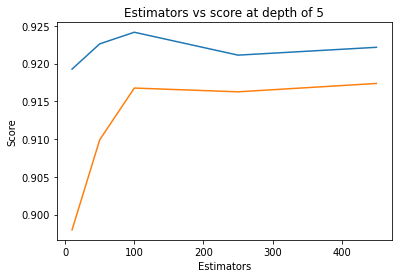

In [80]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.8784026721414363 test Score 0.8576710600722085
depth =  9 Train Score 0.95819948807375 test Score 0.923268950051831
depth =  11 Train Score 0.9604618899951036 test Score 0.9247471113556524
depth =  15 Train Score 0.9643256201369279 test Score 0.9261427273303607
depth =  20 Train Score 0.9652320572218158 test Score 0.9264052785179546
depth =  35 Train Score 0.9653112235566664 test Score 0.9263990524935494
depth =  50 Train Score 0.9653112235566664 test Score 0.9263990524935494
depth =  70 Train Score 0.9653112235566664 test Score 0.9263990524935494
depth =  130 Train Score 0.9653112235566664 test Score 0.9263990524935494


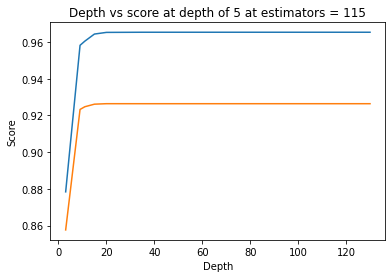

In [81]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

In [84]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=5,cv=10,scoring='f1',random_state=25,return_train_score=True)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.96221474 0.9616967  0.95959466 0.96195268 0.96417363]
mean train scores [0.96332378 0.96242075 0.96027766 0.96270488 0.96525519]


In [85]:
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=14, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=28, min_samples_split=111,
                       min_weight_fraction_leaf=0.0, n_estimators=121,
                       n_jobs=-1, oob_score=False, random_state=25, verbose=0,
                       warm_start=False)


In [0]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [0]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [88]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.965736259499386
Test f1 score 0.9265457926545793


In [0]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


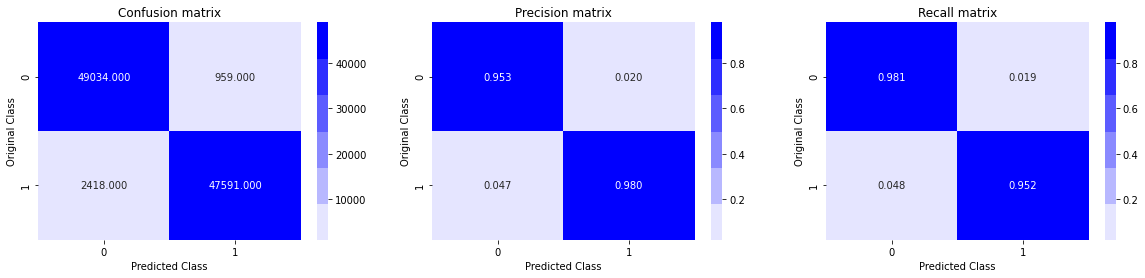

Test confusion_matrix


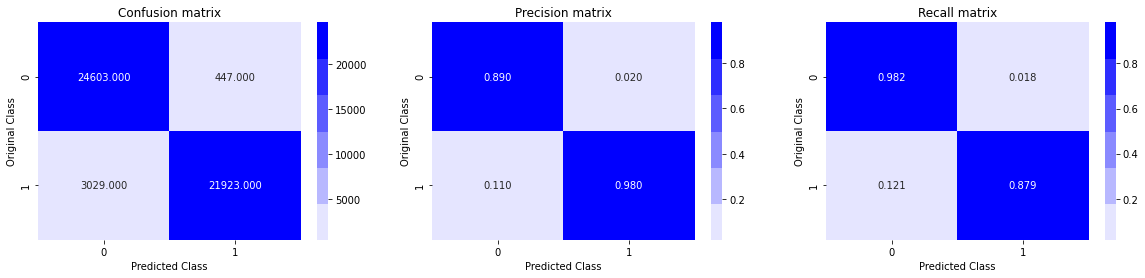

In [91]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

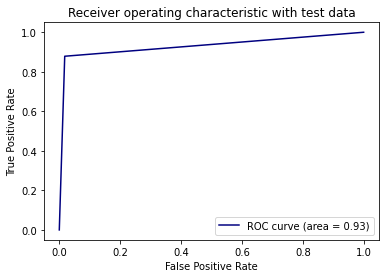

In [92]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

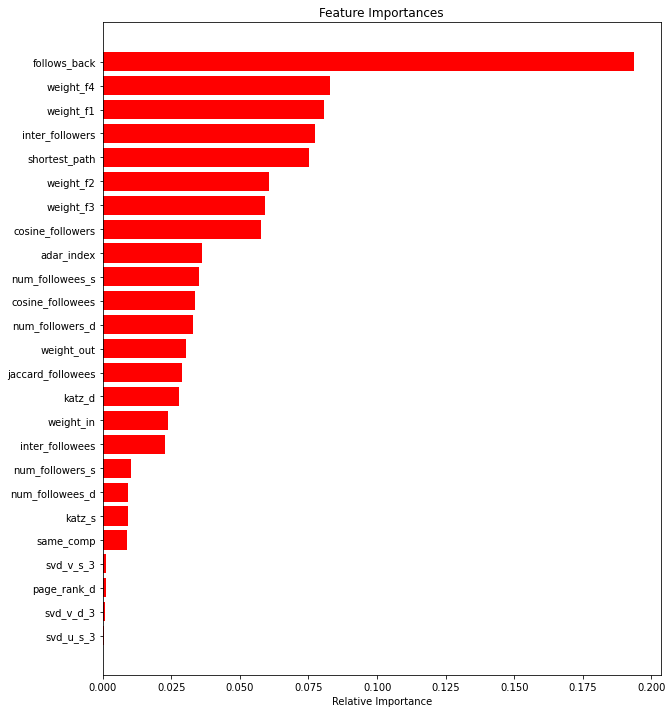

In [93]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [94]:
# apllying XGboost

import xgboost 
clf = xgboost.XGBClassifier()
param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15)
              }
rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=3,scoring='f1',random_state=25,return_train_score=True)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.98054188 0.98051186 0.98028124 0.98073271 0.98077031]
mean train scores [0.99999    1.         0.99468232 0.99746511 0.99786647]


In [97]:
print(rf_random.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=11,
              min_child_weight=1, missing=None, n_estimators=112, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [0]:
clf= xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=11,
              min_child_weight=1, missing=None, n_estimators=112, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [101]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9952858575727183
Test f1 score 0.9256367156748015


Train confusion_matrix


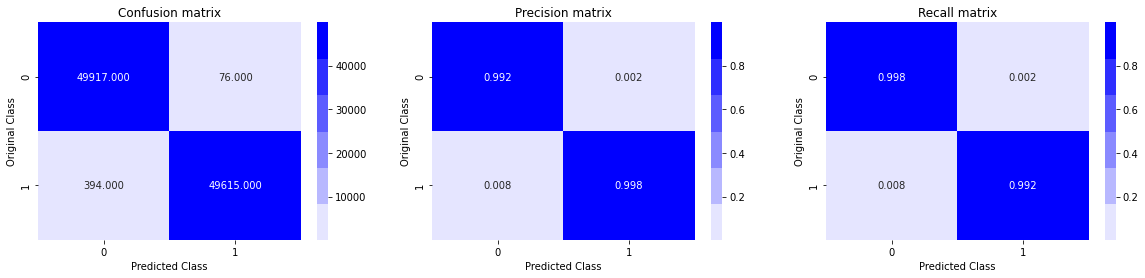

Test confusion_matrix


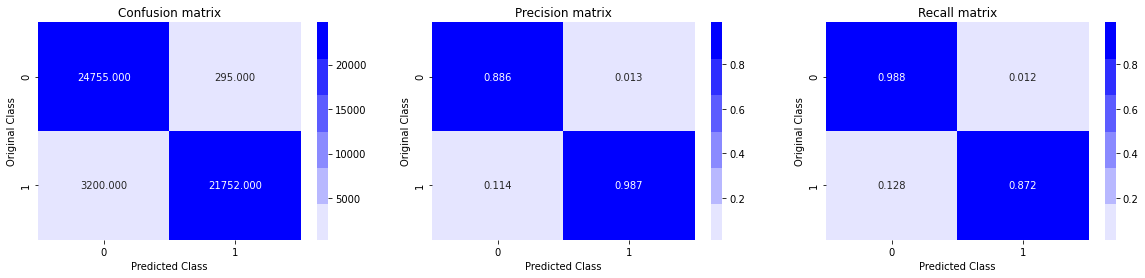

In [102]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

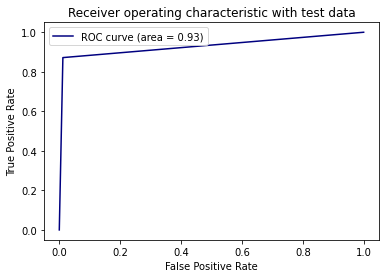

In [103]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

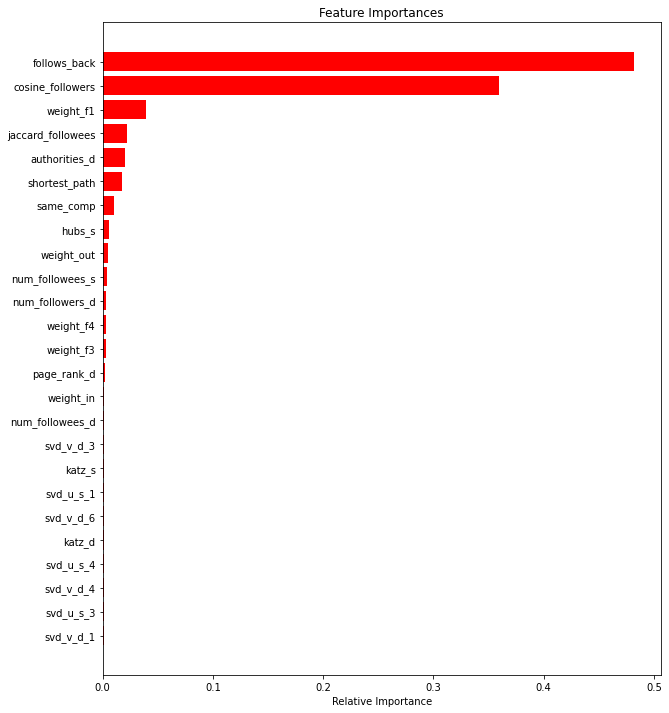

In [104]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [0]:
### END Result :

In [106]:
from prettytable import PrettyTable 
x = PrettyTable()
x.field_names = ["classifier ", "n_estimators", "max_depth", "Train f1-Score","Test f1-Score"]
x.add_row(['Random Forest','121','14','0.965736259499386','0.9265457926545793'])
x.add_row(['XGBOOST','112','11','0.9952858575727183','0.9256367156748015'])
print(x)

+---------------+--------------+-----------+--------------------+--------------------+
|  classifier   | n_estimators | max_depth |   Train f1-Score   |   Test f1-Score    |
+---------------+--------------+-----------+--------------------+--------------------+
| Random Forest |     121      |     14    | 0.965736259499386  | 0.9265457926545793 |
|    XGBOOST    |     112      |     11    | 0.9952858575727183 | 0.9256367156748015 |
+---------------+--------------+-----------+--------------------+--------------------+
